<h1 style="text-align:center;">G/R Count <span style="text-align:center;font-size: 0.5em;">1.0.3</span></h1>
<h3 style="text-align:center;">Zong Lab @ UVA</h3>

# Welcome to G/R Count
#### G/R Count is a computational tool to analyze mutant cell expansion kinetics!
This Jupyter notebook provides you with step-by-step directions to qunatify your stacks.

## 1) Import necessary libraries
In the next cell we import necessary libraries. No user input is required. Just run the cell and proceed to the next cell. 

In [1]:
# Importing data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import re
from copy import deepcopy

#interaction
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import (interact, interactive, fixed,
                        IntSlider, Dropdown, Layout, HBox, Label)
# from ipywidgets import Layout
# from ipywidgets import HBox, Label

#Core functionality
import grcount as grc

#Set Widget Layouts
style = {'description_width': 'initial'}
layout = widgets.Layout(width='90%')

## 2) Locate files

<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">What should I do next? (click here to expand)</span></summary>
    
#### <span style="color:red;">You should interact with the next cell: </span> Please enter the relative/absolute address of the folder that contains your images. 

#### <span style="color:red;">Examples: </span>
* Relative Address
    * Use . if the images are in the same folder as this file
    * If your folder of the images (my_stack) is located in the same directory as this file, you should enter: my_stack in the box and press enter.
* Absolute Address
    *If your images are located on Desktop
        * Mac: you should enter: /Users/username/Desktop/my_stack
        * Windows: you should enter: C:\Users\username\Desktop\my_stack
#### <span style="color:red;">Note: </span>
* It is preferred to have the folder of your images in the same folder as the current file that you are running
* You should press enter after you paste or type the address in the box.
</details>

In [2]:
address,file_list = grc.address()

Where are the files located?

Stack


In [3]:
file_names, stacks, ch = grc.extract_stacks(address,file_list)

Please wait, while we are extrctaing stack info!
You are all set! You may now run the next cell.


## 3) Set the threshold to remove the background noise

<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">What should I do next? (click here to expand)</span></summary>


#### Before measuring the GFP+ and RFP+ area, we should first remove the background noise. The next cell helps you to achieve this goal. 
- You may have different strategies to select the optimal signal threshold. For instance you may pick out the first one of every other 50 stack layers, and based on your observations you can decide on the optimal threshold which removes the background noise for the majority of images without burying the true signals.
    - Please note, once you select a threshold, it will be applied to all of the images.

#### <span style="color:red;">You should interact with the next cell</span> Use the sliders to find the optimal threshold to remove background noise.

</details>


<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">List of parameters that you will adjust in the next cell (click here to expand)</span></summary>

#### Stack Number

* You can use this slider to select different layers of the stack.

#### Green Channel Threshold

* This slider helps you to independently set a threshold on the green channel. The original green channel is shown in the "Green" frame, and the contents of the green channel after the thresholding is displayed in the "Green Mask" frame.

#### Red Channel Threshold

* This slider helps you to independently set a threshold on the red channel. The original red channel is shown in the "Red" frame, and the contents of the red channel after the thresholding is displayed in the "Red Mask" frame.

#### Red Channel Brightness (Visual Only)

* In cases where the signal level in your red channel is low, you can use this slider to instantly increase the brighness in the red channel to better see the details, and make more informed decisions on the right threshold for your red channels.
 - This slider only visually increases the brighness for better visualization and it has no effect on the results.

#### Green Channel Brightness (Visual Only)

* In cases where the signal level in your green channel is low, you can use this slider to instantly increase the brighness in the green channel to better see the details, and make more informed decisions on the right threshold for your green channels.
 - This slider only visually increases the brighness for better visualization and it has no effect on the results.


### How to reset to the default values?
* Just re-run the cell again.
</details>

In [4]:
a = IntSlider(min=min(stacks),max=max(stacks),step=1,
              value=round(int(min(stacks))+(int(max(stacks)))/2),continuous_update=False, description='Stack Number',layout=layout, style=style)
c = IntSlider(min=0,max=255,step=1,value=15,continuous_update=False, description='Green Channel Threshold',layout=layout, style=style)
d = IntSlider(min=0,max=255,step=1,value=15,continuous_update=False, description='Red Channel Threshold',layout=layout, style=style)
e = IntSlider(min=1,max=20,step=1,value=5,continuous_update=False, description='Green Channel Brightness (Visual Only)',layout=layout, style=style)
f = IntSlider(min=1,max=20,step=1,value=5,continuous_update=False, description='Red Channel Brightness (Visual Only)',layout=layout, style=style)

thresholds = [0,0]
image_shape = (0,0,0)
thrs = []

@interact(slide_of_iterest=a, Green_Th=c, Red_Th=d, GreenBright=e, RedBright=f)
def pre_process(slide_of_iterest,Green_Th,Red_Th, GreenBright, RedBright):
    z1 = '%03d' %slide_of_iterest
    test_images = []
    
    for i in file_names:
        if z1 in i:
            test_images.append(i)
    thr = grc.mask_it(address, test_images, Red_Th, Green_Th, RedBright, GreenBright, thresholds, image_shape)
    thrs.append(thr)

interactive(children=(IntSlider(value=71, continuous_update=False, description='Stack Number', layout=Layout(w…

## 4)  Eliminate GFP & RFP double positive zones. 


<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">What should I do next? (click here to expand)</span></summary>


#### In this section, we identify and subtract the GFP & RFP double positive areas within the image (yellow area) to get the true value of GFP only or RFP only positive areas.

With subtraction of yellow area, we get the true green cell area and red area. Finally, through adding up the green area and red area of the whole image sequence, we can acquire the accurate G/R ratio of FT samples.
 

#### <span style="color:red;">You should interact with the next cell: </span> Use the sliders to find the GFP & RFP double positive zones.

</details>

<br>
<details>
<summary><span style="font-size:16px;font-weight: bold; color:red">List of parameters that you will adjust in the next cell (click here to expand)</span></summary>

#### Stack Number

* You can use this slider to select different layers of the stack.

#### Overlap Threshold

* This slider is used to define and remove the GFP & RFP double positive zones (yellow areas in the original image). By changing the value of this slider you are selecting a minimum acceptable signal ratio at each pixels that is considered an overlap.

### What do different frames show?
* Red Mask: Thresholded red channel (Previous step)
* Green Mask: Thresholded green channel (Previous step)
* Red mask after removing the yellow area: Areas where only the red channel is stained
* Green mask after removing the yellow area: Areas where only the green channel is stained
* Original image with overlaid channels: Exactly wht the name suggests
* Original image with overlaid channels after removing the yellow area: Areas within the cell where only GFP or RFP and not both of them are positive

### How to reset to the default values?
* Just re-run the cell again.
</details>

In [5]:
g = IntSlider(min=min(stacks),max=max(stacks),step=1,value=round(int(min(stacks))+(int(max(stacks)))/2),continuous_update=False, description='Slide of Interest',layout=layout, style=style)
h = widgets.FloatSlider(min=0.0,max=5.0,step=0.1, value=1, continuous_update=False,  description='Overlap Threshold', layout=layout, style=style)

func_settings = [0,0]
non_coloc_mask_array = []

@interact(slide_of_iterest=g, Green_Red_ratio=h)
def pre_process(slide_of_iterest,Green_Red_ratio):
    z1 = '%03d' %slide_of_iterest
    test_images = []
    for i in file_names:
        if z1 in i:
            test_images.append(i)
    
    grc.remove_yellow(address, test_images,slide_of_iterest, Green_Red_ratio, thrs[-1],func_settings,non_coloc_mask_array)

interactive(children=(IntSlider(value=71, continuous_update=False, description='Slide of Interest', layout=Lay…

# 5) Measure the signal ratio
#### Just run the following cells to measure the GR ratio across the stack images.

In [6]:
non_coloc_mask = non_coloc_mask_array[-1]

In [7]:
measurements = grc.measure_it(address,non_coloc_mask, file_names,ch,thrs[-1],measures=None)

Please wait while we are measuring the ratios!


/Users/ali/Downloads/Zong Lab/grcount.py:186: RuntimeWarning: divide by zero encountered in long_scalars
  measures.append((stack,dst2.sum(),dst1.sum(), (dst2.sum()/dst1.sum()),((dst1.sum()/dst2.sum()))))



 You are all set! You may now proceed to the next cell.


# 6) Check the results

In [8]:
opts = ['Keep the data as is', 'Remove the channels where the signal at one or both channels is zero']
measurements_cleaned = deepcopy(measurements)

@interact(choices = Dropdown( options=opts, description='What to do with the data?',layout=layout, style=style))
def pre_process(choices):
    if choices == 'Keep the data as is':
        measurements.fillna(0, inplace=True)
        measurements_cleaned = deepcopy(measurements)
        measurements_cleaned = pd.DataFrame(measurements_cleaned.values)
        measurements_cleaned.columns = ['Stack','Red Area', 'Green Area', 'Red/Green Ratio','Green/Red Ratio']
        print('We replaced the Inf (num/zero) and Nan (zero/zero) with 0 in the table.\n')
        print('Here are the first 5 lines of your data:\n')
        print(measurements.head())
    else:
        measurements.dropna(inplace=True, axis=0)
        measurements_cleaned = deepcopy(measurements)
        measurements_cleaned = pd.DataFrame(measurements_cleaned.values)
        measurements_cleaned.columns = ['Stack','Red Area', 'Green Area', 'Red/Green Ratio','Green/Red Ratio']
        print('Here are the first 5 lines of your data:\n')
        print(measurements_cleaned.head())
     

interactive(children=(Dropdown(description='What to do with the data?', layout=Layout(width='90%'), options=('…

# Summary of the measurements
### Statistical summary of the measured features along the stack of images.

In [9]:
summary_data = measurements.describe()
sum_data = grc.stack_sum(measurements)

In [10]:
print('Statistical Summary of the features along the stack.')
summary_data

Statistical Summary of the features along the stack.


,Green Area,Red Area,Green/Red Ratio,Red/Green Ratio
count,140.000000,140.000000,140.000000,140.000000
mean,22519.314286,1812.242857,22.158063,4.350845
std,23756.079535,1295.922254,41.848345,29.402994
min,1.000000,0.000000,0.000000,0.000000
25%,1802.000000,634.000000,1.866242,0.043802
50%,10621.500000,1636.500000,11.312472,0.085922
75%,47400.250000,2736.000000,22.283814,0.514402
max,67953.000000,5018.000000,288.660000,247.000000


In [11]:
print('G/R Ratio Measurement.')
sum_data

G/R Ratio Measurement.


,Total Green Area along the Stack,Total Red Area along the Stack,Green/Red Ratio of the stack,Red/Green Ratio of the stack
Stack Results,,,,
>>>,3152704.0,253714.0,12.426212,0.080475


# 7) Plot the signal ratio across the stack

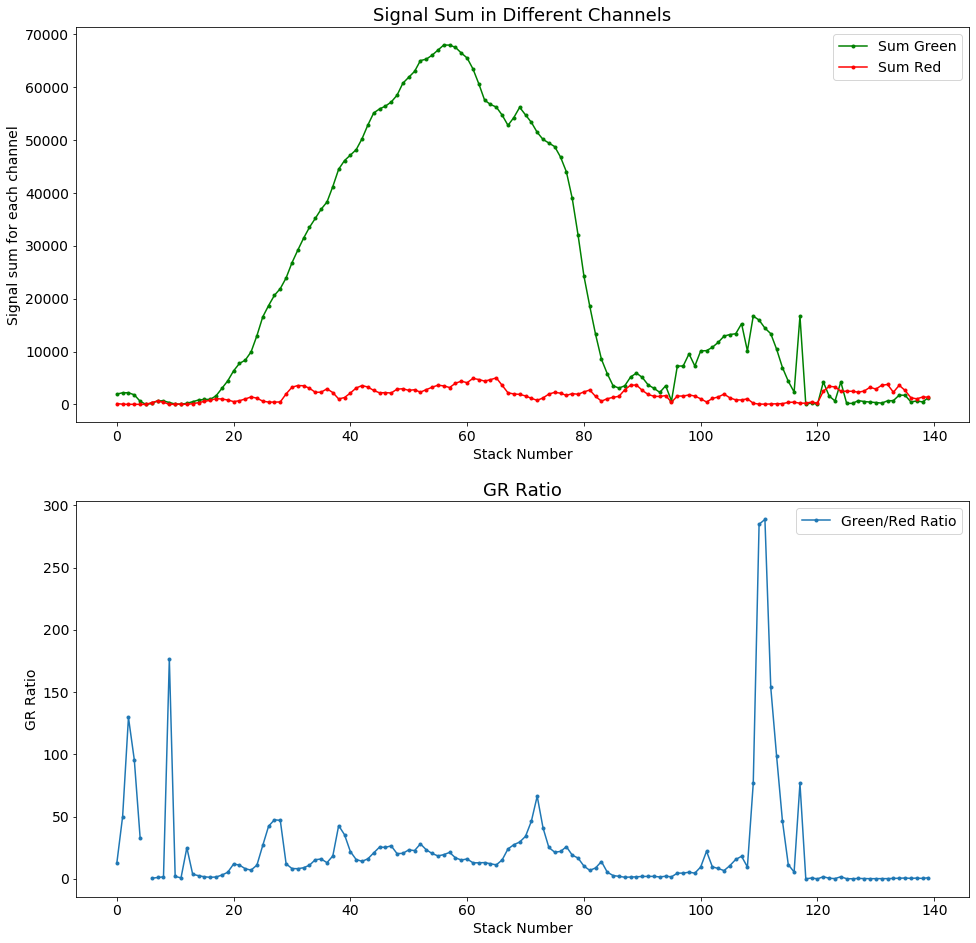

In [12]:
grc.plot_results(measurements_cleaned)

# 8) Export the results

#### Run the next cell to export your measurements.
#### The files will be saved in the same folder as this Jupyter notebook is located.

In [13]:
measurements_cleaned.to_csv('Stack_measurements.csv')
summary_data.to_csv('Stack_summary.csv')

# The End!